In [1]:
import os
import sys
import dcor
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split

from dowhy import CausalModel

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer
from auto_causality.datasets import iv_dgp_econml
from auto_causality.params import SimpleParamService

warnings.filterwarnings("ignore")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Model fitting & scoring

Here we fit a (selection of) model(s) to the data and score them with the energy distance score on held-out data.

We create a synthetic dataset and pre-process it with a DGP described [here](https://github.com/microsoft/EconML/blob/main/notebooks/OrthoIV%20and%20DRIV%20Examples.ipynb). The dataset size, number of features and constant true effect, can be varied.

In [2]:
TE = 11.50
data = iv_dgp_econml(n=5000, p=15, true_effect=TE)

treatment = data.treatment
targets = data.outcomes
instruments = data.instruments
data_df, features_X, features_W = preprocess_dataset(
    data.data, treatment, targets, instruments
)

outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)
Xtest = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
938,0.0,3.914192,0.0,0.587055,0.764257,-0.747508,-0.257750,-0.847863,-0.098703,-0.603434,1.004176,-0.664102,-0.448736,-0.033512,0.780575,1.992158,0.155966,0.425341,1.0
1589,0.0,1.306556,1.0,-0.527349,-1.011669,-0.774687,-0.555224,0.891026,1.839626,-1.306607,-1.280900,-0.646366,-0.966381,-0.332132,-0.308434,-2.266628,1.269205,1.317997,0.0
2647,1.0,19.935253,1.0,-0.138821,-0.849086,0.370397,-0.532056,-1.056580,1.598664,-0.841640,0.756526,1.336702,0.934166,-2.254221,-0.906043,-1.442950,-0.485301,0.512879,0.0
305,0.0,6.510473,0.0,-1.816131,-0.025697,1.666074,0.388907,-0.433187,0.133935,-0.826289,-0.982992,-0.246197,-0.046338,-0.196407,-0.539211,-0.719284,1.716316,-0.995706,1.0
449,1.0,17.317398,1.0,1.006914,1.016560,0.420847,-0.714000,-0.610549,-0.174740,2.360098,2.161623,-0.240828,1.340513,-0.410896,0.836990,1.715416,-0.001117,-1.342481,1.0


If you want to use specific estimators, pass these as a list to `estimator_list` param in `AutoCausality`. IV estimators are listed in `all_estimators` below.

The other allowed values are `all` and `auto`, the default is `auto`.

For IV models, currently specify `auto` for propensity model, and instruments when

Fitting the model is as simple as calling AutoCausality.fit(), with the only required parameter apart from the data being the `instruments` for IV models.



In [ ]:
ac = AutoCausality(
    verbose=3,
    components_verbose=2,
    components_time_budget=300,
    propensity_model="auto",
)

ac.fit(train_df, treatment, outcome, features_W, features_X, instruments)

In [ ]:
ac_estimator_effect = ac.model.estimator.effect(Xtest).mean()

In [ ]:
print("(AutoCausality Estimator)")
print(f"Estimator: {ac.best_estimator}")
print(f"Config: {ac.best_config}")
print(f"Energy distance score: {ac.best_score}")

### Baseline Estimators

For comparison, we take the best default configuration of all integrated IV estimators as a baseline, and compare the ATE and energy distance scores, with the best AutoCausality configuration.

In [ ]:
params = SimpleParamService(propensity_model=None, outcome_model=None)
iv_estimators = params.estimator_names_from_patterns("iv", "auto")

In [ ]:
# Baseline comparisons: IV models with default conigurations
baseline_scores = {}
for est_name in iv_estimators:
    model = CausalModel(
        data=train_df,
        treatment=treatment,
        outcome=outcome[0],
        effect_modifiers=features_X,
        common_causes=["random"],
        instruments=instruments,
    )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(
        identified_estimand,
        method_name=est_name,
        method_params={
            "init_params": {},
            "fit_params": {},
        },
        test_significance=False,
    )

    base_effect_ = estimate.estimator.effect(Xtest).mean()
    base_energy_dist = Scorer.energy_distance_score(estimate, test_df)

    baseline_scores[est_name] = {
        "effect": base_effect_,
        "energy_distance": base_energy_dist
    }

baseline_estimator, baseline_metrics = sorted(baseline_scores.items(), key=lambda x: x[1]["energy_distance"])[0]

print("(Best baseline)")
print("Estimator: ", baseline_estimator)
print("Energy distance score: ", baseline_metrics["energy_distance"])


#### Comparing Treatment Effect

In [ ]:
print("True Treatment Effect  = ", TE)
print("(Baseline) Treatment Effect: ", baseline_metrics["effect"])
print("(AutoCausality) Treatment Effect: ", ac_estimator_effect)

In [ ]:
from auto_causality.models import SimpleIV

# Needed since ac.model.estimator doesn't include additional params -
# treatment, outcome etc. - needed from CausalEstimate instance
def energy_scorer_patch(
    df: pd.DataFrame,
    treatment: str,
    outcome: str,
    instrument: str,
    effect_modifiers: list,
    **kwargs
):
    if "estimate" in kwargs.keys():
        est = kwargs["estimate"]
        if type(est) == SimpleIV:
            df["dy"] = est.effect(df[effect_modifiers])
        else:
            df["dy"] = est.estimator.effect(df[effect_modifiers])
    # Compute Energy distance for True & No Effect
    elif "true_effect" in kwargs.keys() and "ne" in kwargs.keys():
        df["dy"] = (
            [0] * len(df) if kwargs["ne"] is True
            else [kwargs["true_effect"]] * len(df)
        )

    df.loc[df[treatment] == 0, "dy"] = 0
    df["yhat"] = df[outcome] - df["dy"]

    X1 = df[df[instrument] == 1]
    X0 = df[df[instrument] == 0]
    select_cols = effect_modifiers + ["yhat"]

    energy_distance_score = dcor.energy_distance(X1[select_cols], X0[select_cols])

    return energy_distance_score

In [ ]:
print("Energy distance scores")
base_estimator_edist = Scorer.energy_distance_score(estimate, test_df)
ac_estimator_edist = energy_scorer_patch(
    test_df, treatment, outcome, instruments[0], features_X, estimate=ac.model.estimator
)
ac_estimator_edist_ne = energy_scorer_patch(
    test_df, treatment, outcome, instruments[0], features_X, true_effect=TE, ne=True
)
ac_estimator_edist_te = energy_scorer_patch(
    test_df, treatment, outcome, instruments[0], features_X, true_effect=TE, ne=False
)
print("\n(Baseline) Energy distance score: ", base_estimator_edist)
print("(AutoCausality) Energy distance score: ", ac_estimator_edist)
print("\n(No Effect) Energy distance score: ", ac_estimator_edist_ne)
print("(True Effect) Energy distance score: ", ac_estimator_edist_te)

## Visualizing Model Interpretability

In [ ]:
# score all estimators on the test set, which we've kept aside up till now
for est_name, scr in ac.scores.items():
    causal_estimate = scr['estimator']
    scr['scores']['test'] = ac.scorer.make_scores(causal_estimate, test_df, problem=ac.problem, metrics_to_report=ac.metrics_to_report)

In [6]:
# score all estimators on the test set, which we've kept aside up till now
for est_name, scr in ac.scores.items():
    causal_estimate = scr['estimator']
    scr['scores']['test'] = ac.scorer.make_scores(causal_estimate, test_df, problem=ac.problem, metrics_to_report=ac.metrics_to_report)

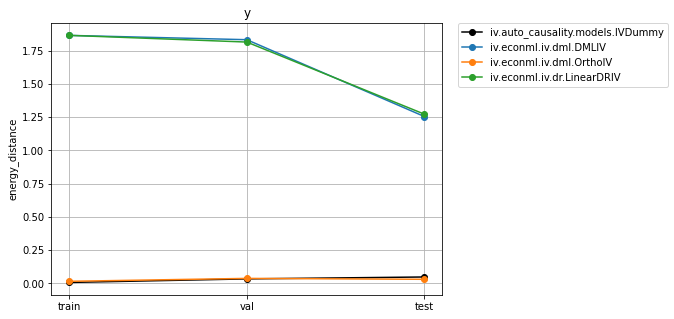

In [7]:
# Compare all estimator performance

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])


plt.figure(figsize = (7,5))
plt.title(outcome)

m1 = "energy_distance"

for (est, scr), col in zip(ac.scores.items(), colors):
    try:
        sc = [scr["scores"]['train'][m1], scr["scores"]['validation'][m1], scr["scores"]['test'][m1]]
        plt.plot(sc, color=col, marker="o", label=est)
        plt.xticks(np.arange(3), ['train', 'val', 'test'])

    except:
        pass

plt.ylabel(m1)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


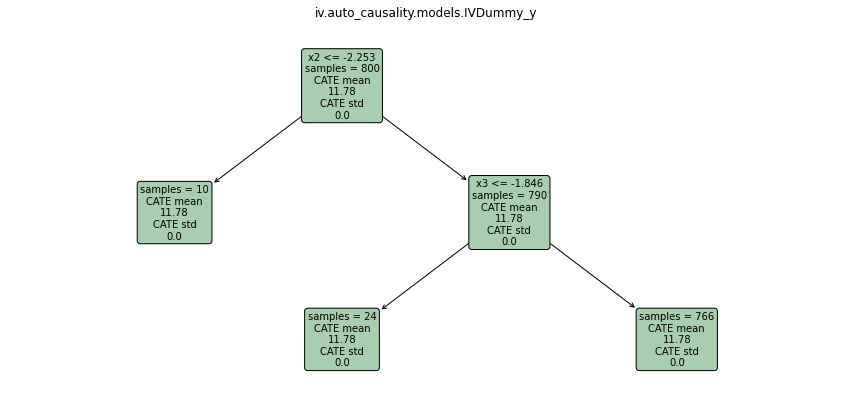

In [8]:
# SingleCATE Tree Interpreter
scr = ac.scores[ac.best_estimator]
intrp = scr["scores"]['validation']['intrp']
plt.figure(figsize=(15, 7))
intrp.plot(feature_names=intrp.feature_names, fontsize=10)
plt.title(f"{ac.best_estimator}_{outcome}")
plt.show()

In [9]:
# Feature importance with SHAP explainer
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = test_df.sample(100)

scr = ac.scores[ac.best_estimator]
est = ac.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()

'IVDummy' object has no attribute 'shap_values'


AttributeError: 'IVDummy' object has no attribute 'estimator'